In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split('_')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+'_t.png')
        maskNames.append(unames[i]+'_i2.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj


In [4]:
framObjTrain = LoadData( framObjTrain, imgPath = 'archive'
                        , maskPath = 'archive'
                         , shape = 128)

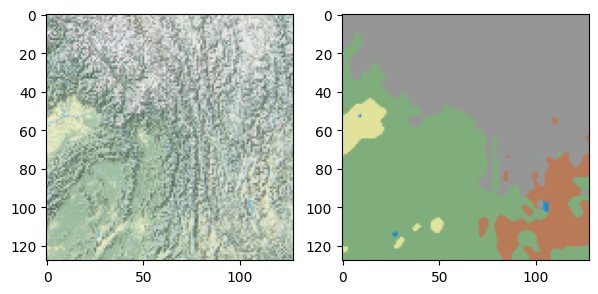

In [5]:
plt.figure(figsize = (7, 5))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()


In [6]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    

    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


In [7]:
inputs = tf.keras.layers.Input((128, 128, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [8]:
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 2, verbose = 1)

Epoch 1/2
157/157 [==============================] - 209s 1s/step - loss: 0.5971 - accuracy: 0.6896
Epoch 2/2
157/157 [==============================] - 195s 1s/step - loss: 0.5671 - accuracy: 0.7742


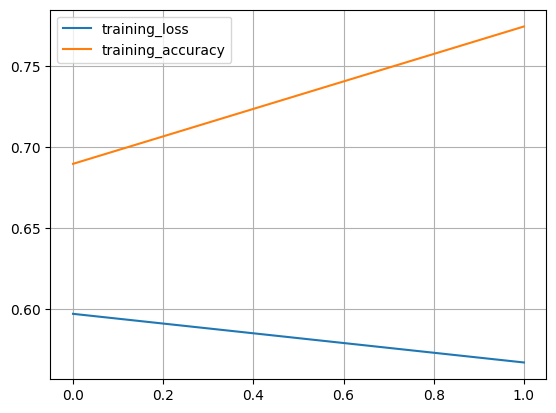

In [9]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [10]:
def predict16 (valMap, model, shape = 256):
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Terrain Image')
    
    filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) 
    imgSharpen = cv2.filter2D(predMask,-1,filter)
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Terrain Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Terrain Mask')


157/157 [==============================] - 54s 328ms/step


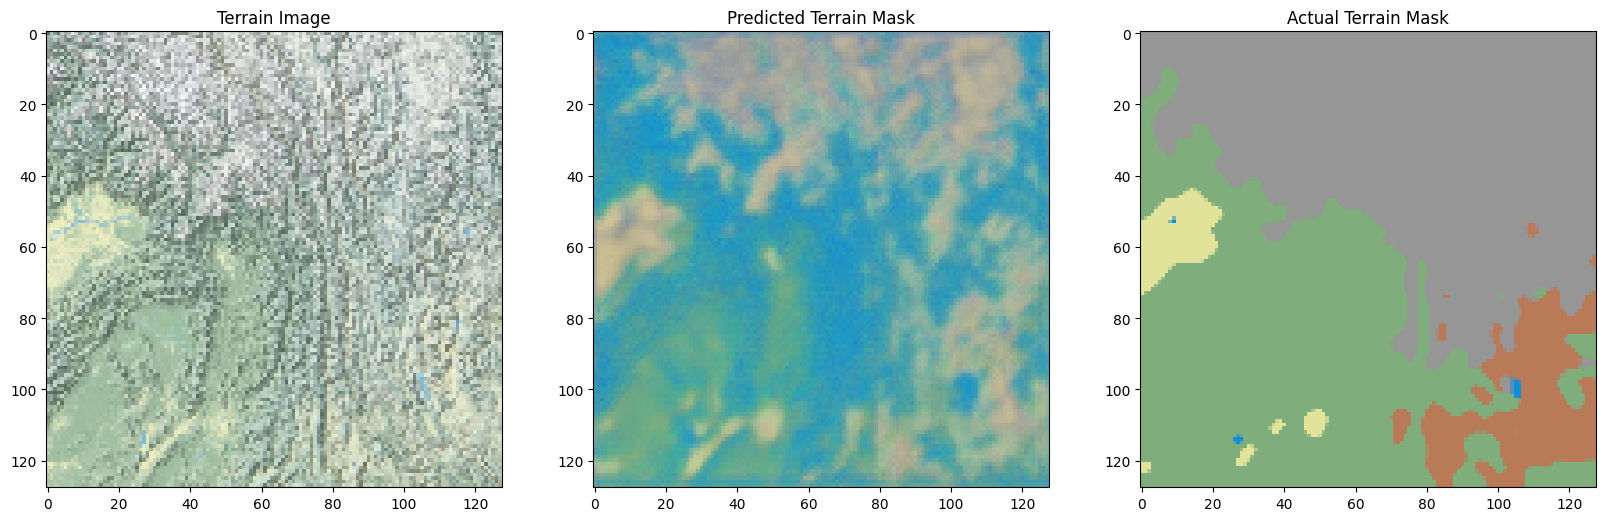

In [11]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)
Plotter(actuals[1], sixteenPrediction[1], masks[1])

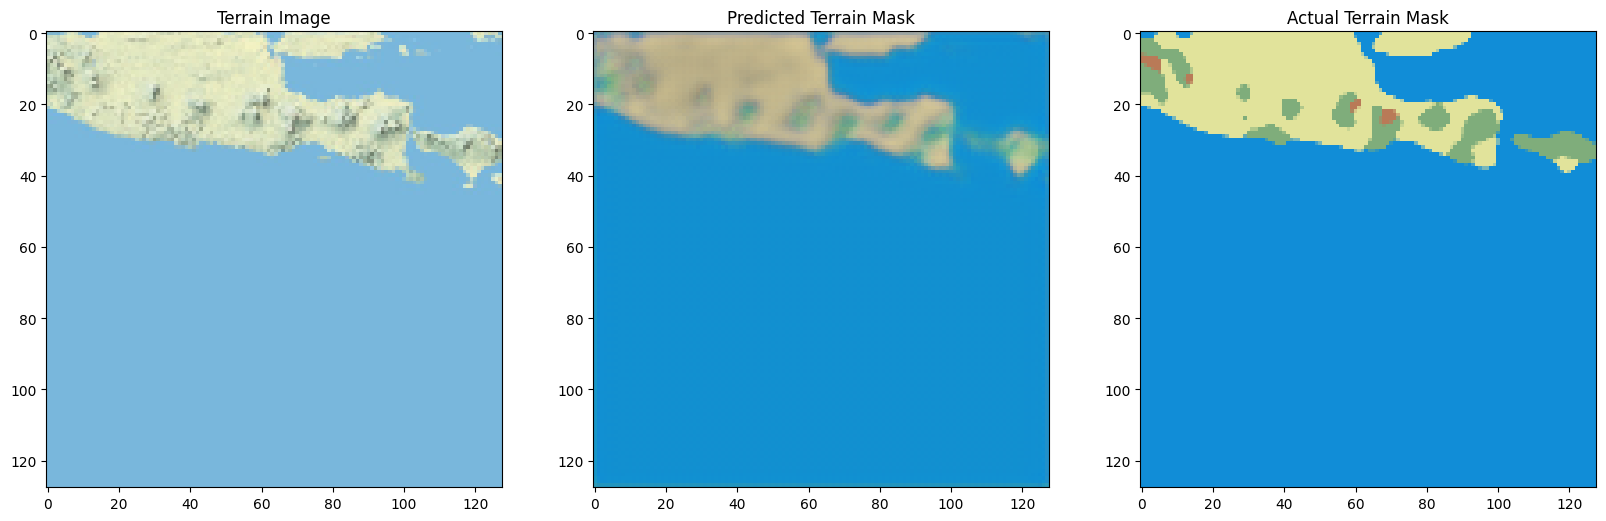

In [12]:
Plotter(actuals[2], sixteenPrediction[2], masks[2])

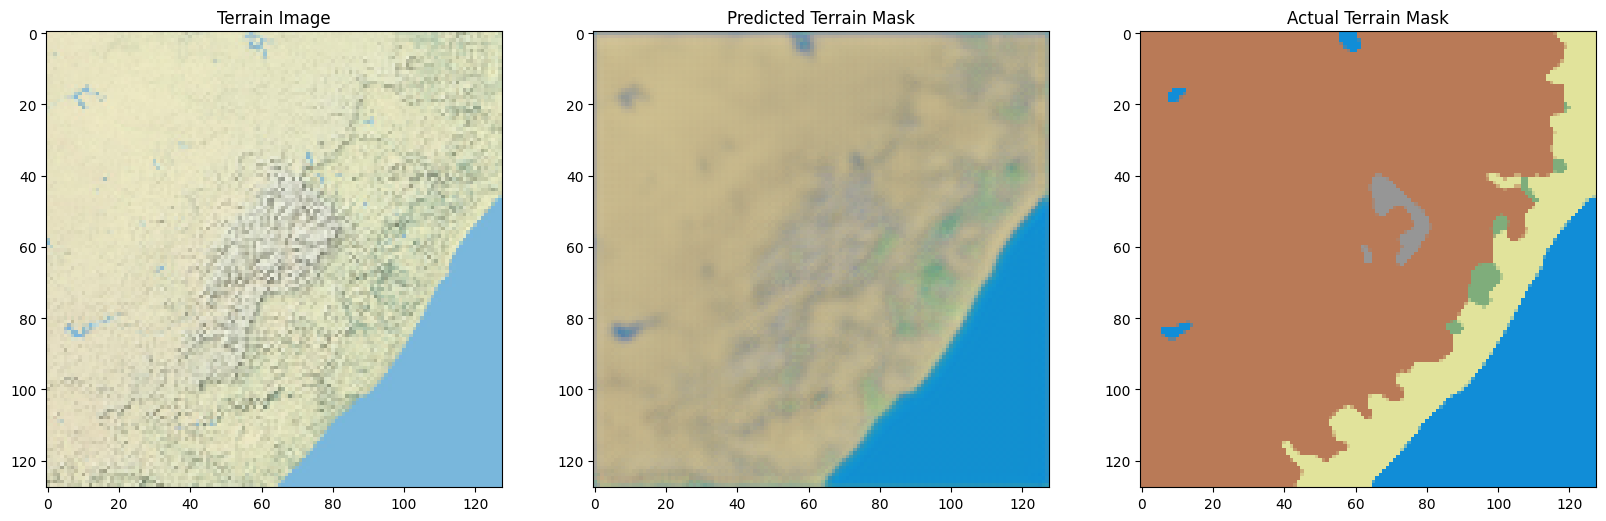

In [14]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])

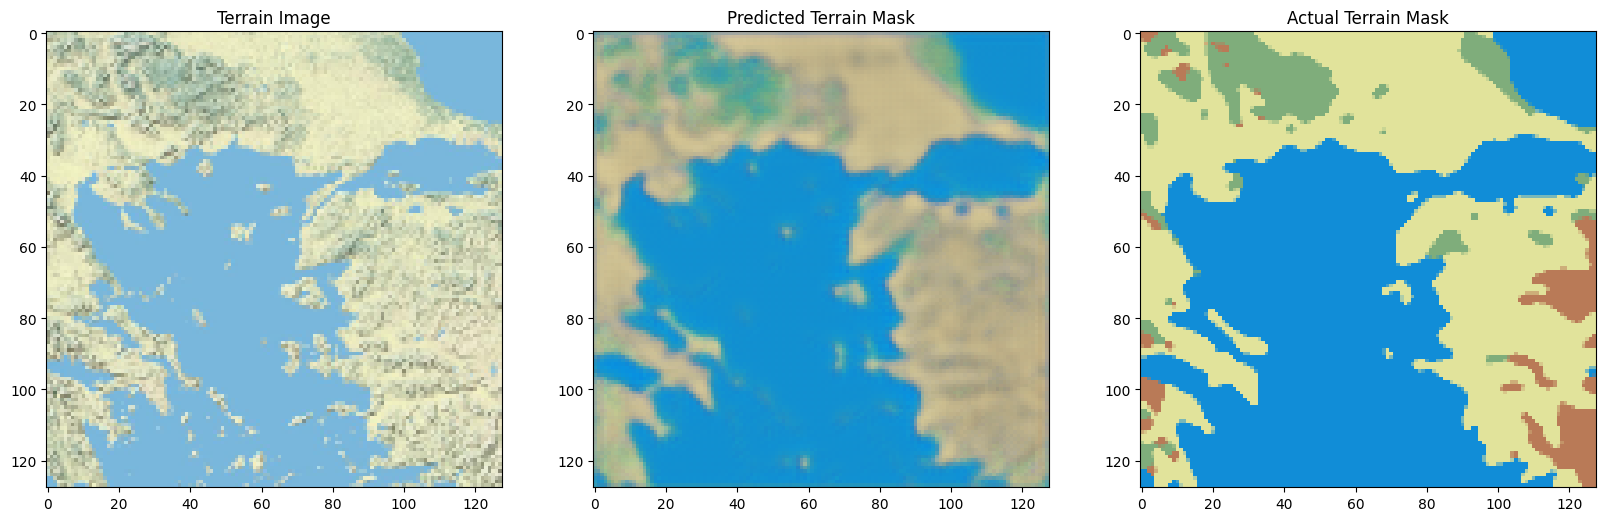

In [15]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])

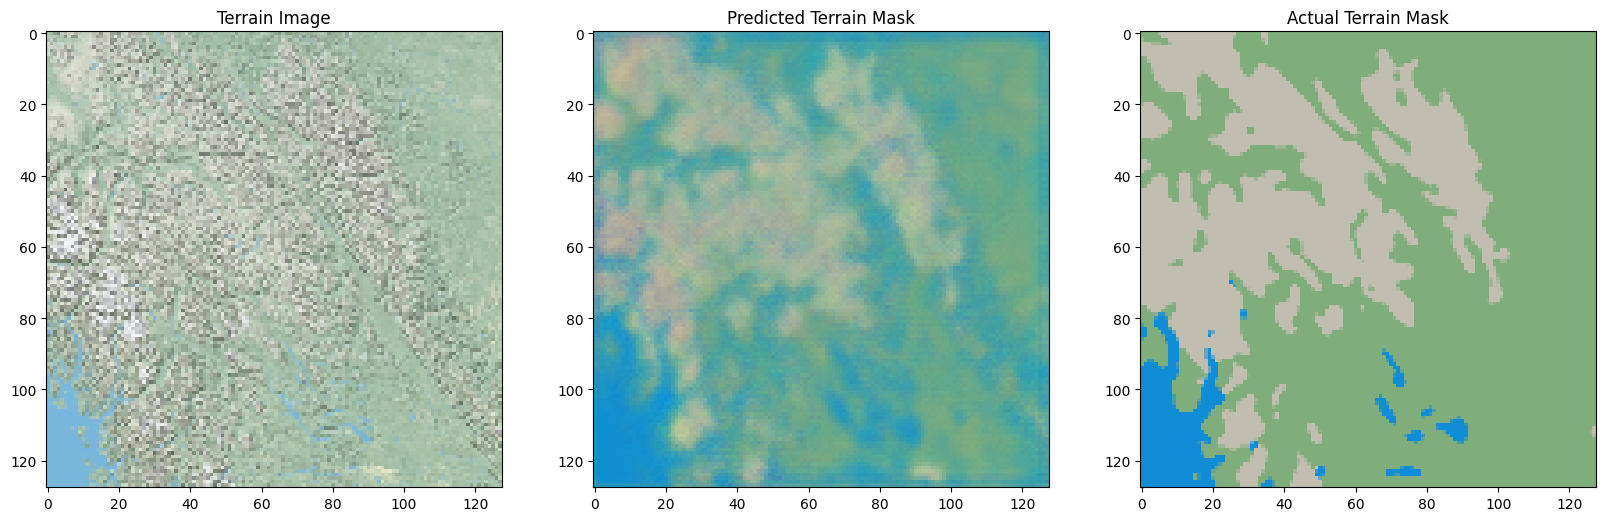

In [16]:
Plotter(actuals[5], sixteenPrediction[5], masks[5])

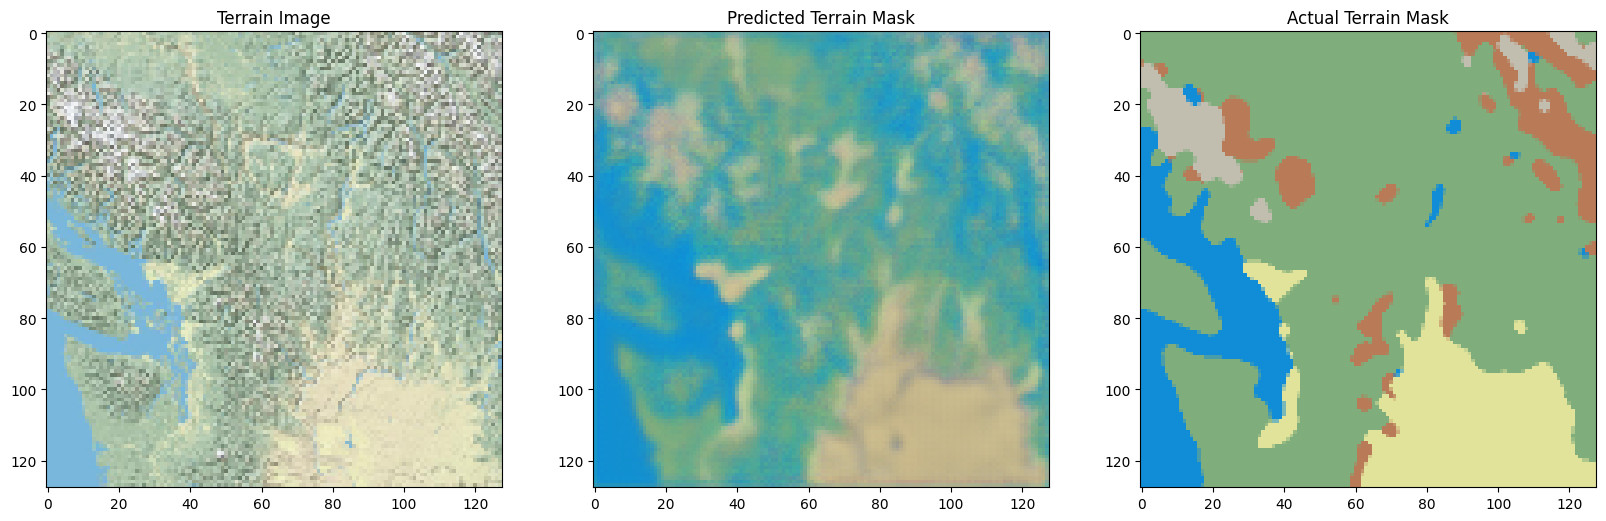

In [17]:
Plotter(actuals[6], sixteenPrediction[6], masks[6])

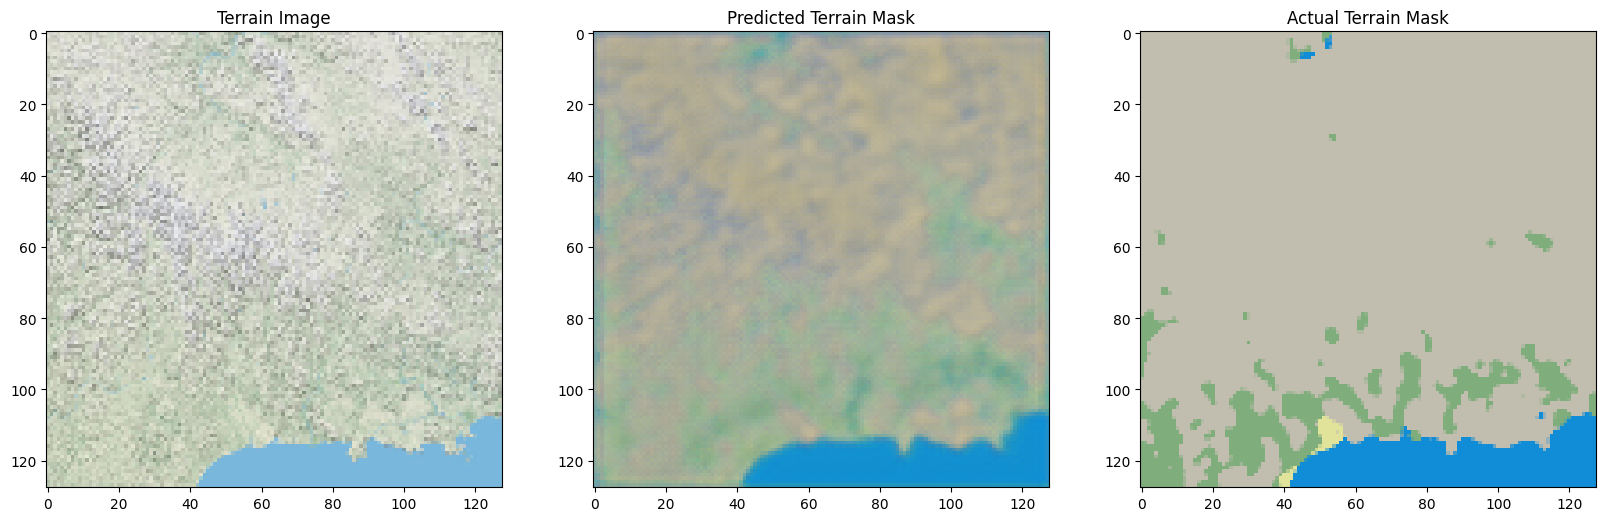

In [18]:
Plotter(actuals[7], sixteenPrediction[7], masks[7])

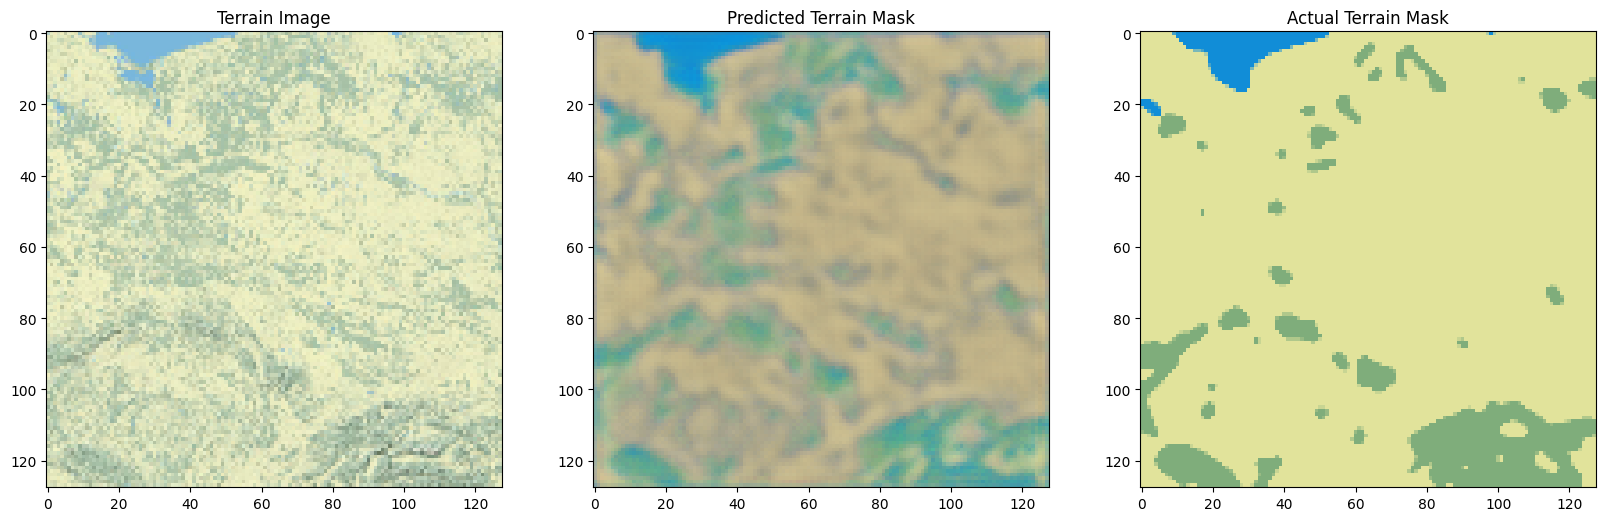

In [19]:
Plotter(actuals[8], sixteenPrediction[8], masks[8])

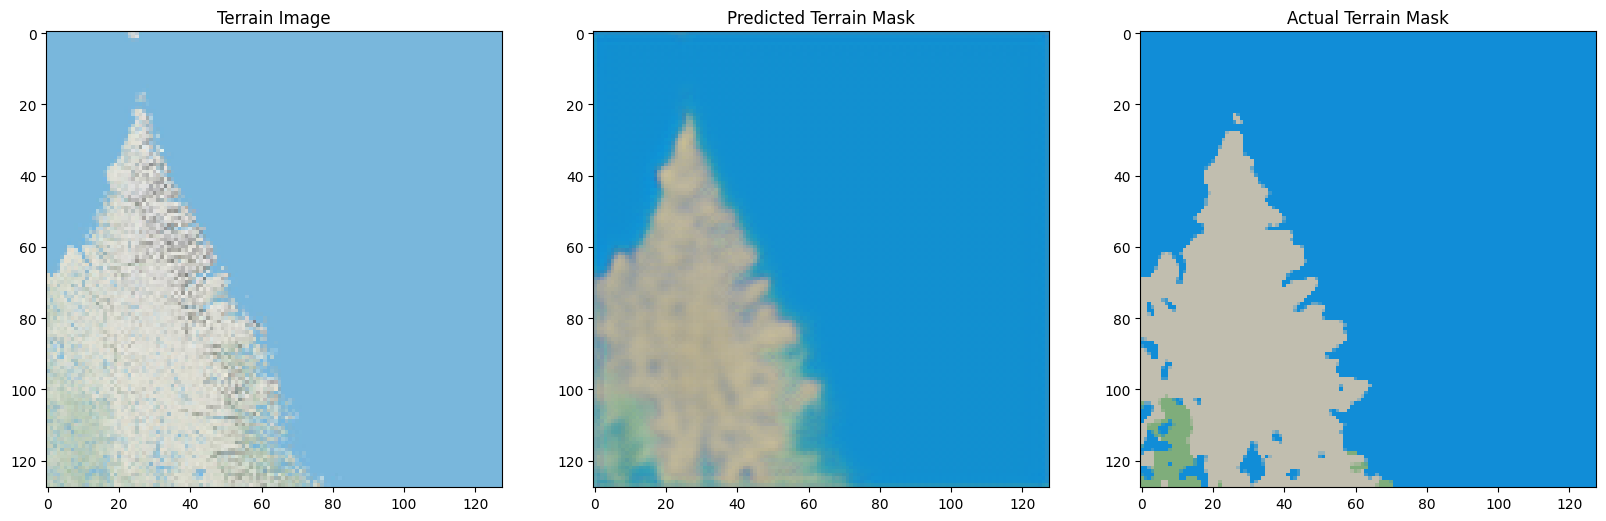

In [20]:
Plotter(actuals[9], sixteenPrediction[9], masks[9])

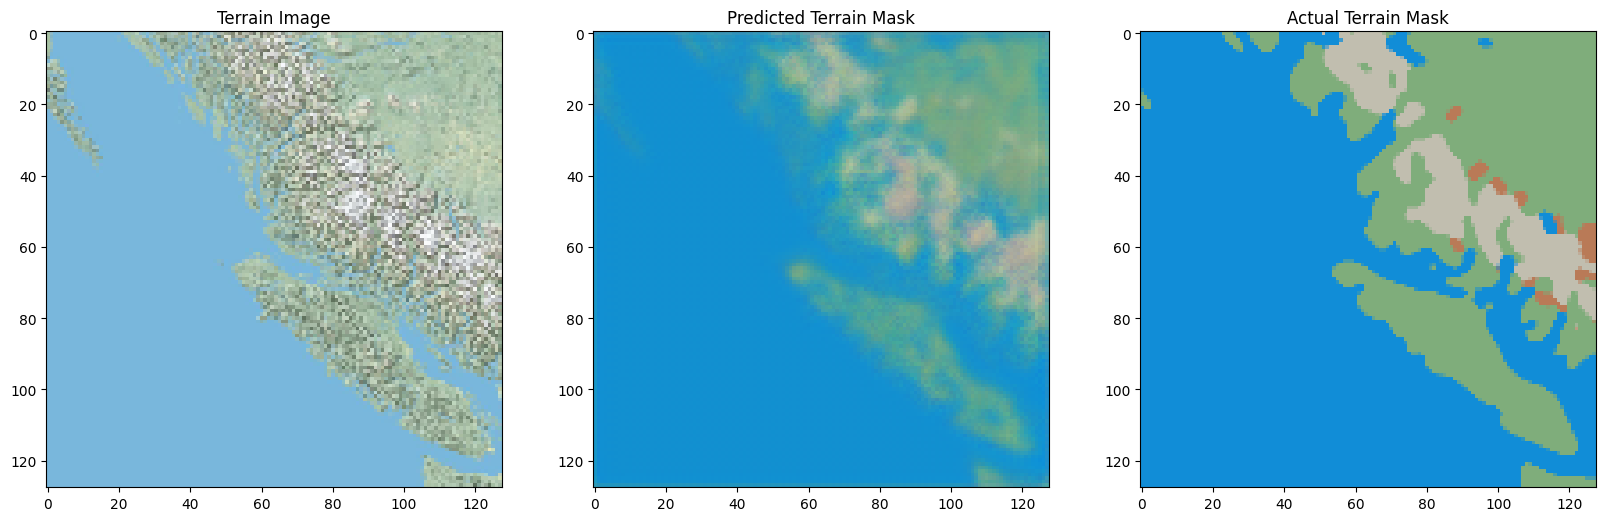

In [22]:
Plotter(actuals[10], sixteenPrediction[10], masks[10])

In [25]:
myTransformer.save('TerrainGenerator.h5')